# Gene prioritisation
Collect additional information about genes to prioritise them during results interpretation of other analyses (with focus on postnatal beta cells):
- Expression strength (N cells, mean expression in expr cells)
- Relative expression in beta cells
- N gene sets (Recon, KEGG, GO)
- N PubMed IDs

In [34]:
import scanpy as sc
import pandas as pd
import numpy as np
import pickle as pkl
import time

from sklearn.preprocessing import minmax_scale, maxabs_scale

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams

from indra import literature

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

In [2]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

ro.r('library("hypeR")')
ro.r("source(paste(Sys.getenv('WSCL'),'diabetes_analysis/data_exploration/','helper_hypeR.R',sep=''))")

value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


In [3]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'

In [4]:
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')
adata_rn_b.shape

(102143, 30672)

In [5]:
# Remove genes expressed in less than 20 cells
sc.pp.filter_genes(adata_rn_b, min_cells=20)
adata_rn_b.shape

(102143, 19351)

## Make genes DF

In [6]:
# genes DF
genes=pd.DataFrame(index=adata_rn_b.var_names)

In [28]:
# gene symbol info
genes['gene_symbol']=adata_rn_b.var['gene_symbol']

### Add relative beta expression
Relative expression in beta cells compared to other cell types.

#### Relative across cts

In [114]:
# Load avg expression across cts
avg_expr_ct=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/data_integrated_ctAvgScaled_sfintegrated.tsv',index_col=0)
avg_maxscl_expr_ct=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/data_integrated_ctAvgMaxScaled_sfintegrated.tsv',index_col=0)

In [115]:
# Add relative expr info
genes['rel_beta_expr']=avg_expr_ct.loc[genes.index,'beta']
genes['rel_maxscl_beta_expr']=avg_maxscl_expr_ct.loc[genes.index,'beta']

#### Relative across cls
Since cells may be heterogeneous within cell types also compute relative expression across finer clusters and then assign to beta cells the maximal relative expression across clusters that are predominately composed of beta cells.

In [8]:
# Load adata
adata_full=sc.read(path_data+'data_integrated_analysed.h5ad',backed='r')
# Load rawnorm. Correctly norm expression is in layers X_sf_integrated
adata_rawnorm=sc.read(path_data+'data_rawnorm_integrated_annotated.h5ad',backed='r')

##### Cluster data

In [13]:
cl_col_full='leiden_r2'
ct_col='cell_type_integrated_v1'
adata_rawnorm.obs[cl_col_full]=adata_full.obs[cl_col_full]

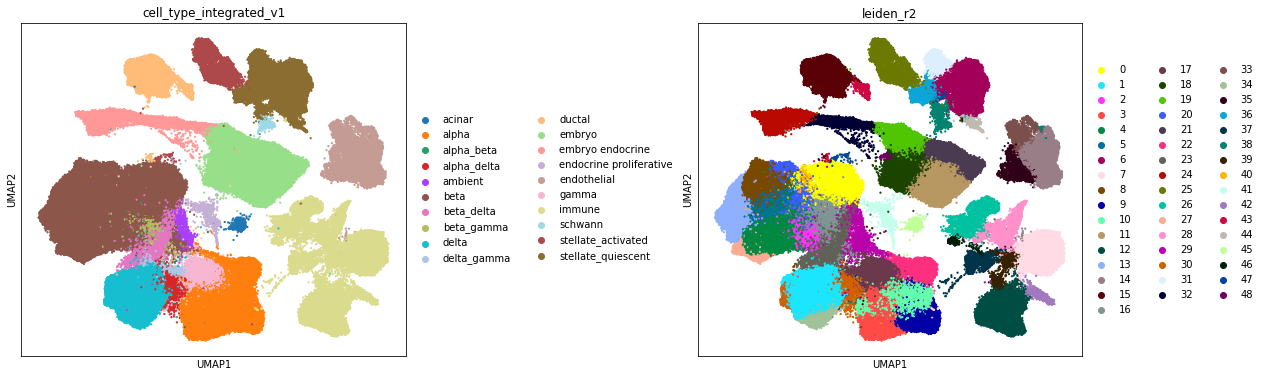

In [14]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_full,color=[ct_col,cl_col_full],s=20,wspace=0.6)

Most common ct in each cl and its ratio

In [15]:
# Most common ct ratio per cl
main_ct=adata_full.obs.groupby(cl_col_full).apply(lambda x: x[ct_col].value_counts(normalize=True
                                                                          ).head(n=1))
display(main_ct)

leiden_r2                         
0          beta                       0.996583
1          delta                      0.977412
2          beta                       0.987390
3          alpha                      0.997339
4          beta                       0.996420
5          beta                       0.999119
6          stellate_quiescent         0.999754
7          immune                     0.999632
8          beta                       0.997646
9          alpha                      0.997068
10         alpha                      0.987334
11         embryo                     0.999706
12         immune                     1.000000
13         beta                       0.988441
14         endothelial                0.999439
15         ductal                     0.998144
16         beta                       0.753274
17         gamma                      0.936404
18         embryo                     0.999718
19         embryo                     0.963941
20         beta          

Other most common cts in cls that are not composed predominately of one ct.

In [16]:
# Most common cts in each cl that is not composed mainly of one ct
unclean_cls=[cl for cl,ct in main_ct[main_ct<0.9].index]
adata_full[adata_full.obs[cl_col_full].isin(unclean_cls),:].\
    obs.groupby(cl_col_full).apply(lambda x: x[ct_col].value_counts(normalize=True
                                                                          ).head(n=3))

leiden_r2                    
16         beta                  0.753274
           beta_gamma            0.151740
           alpha_beta            0.073555
23         beta_delta            0.886048
           delta_gamma           0.055031
           delta                 0.022049
29         beta                  0.658960
           ambient               0.254031
           alpha                 0.040462
30         alpha_delta           0.556398
           delta                 0.402844
           delta_gamma           0.022117
38         stellate_quiescent    0.531295
           schwann               0.448326
           endothelial           0.013828
47         stellate_activated    0.639785
           stellate_quiescent    0.338710
           beta                  0.016129
Name: cell_type_integrated_v1, dtype: float64

C: Most cell clusters are mainly composed of single cell type. There are a few exceptions. Those that are non-beta are not that relevant. Those that are beta mainly seem to be well represented by the beta ct. Exception is cl 29 which may be low quality beta cells.
Doublets will not be used as they are mixture of reall cell types. Embryo clusters will be removed from comparison as they for sure can not contribute to ambience in postnatal beta cells. 

In [17]:
# Map cl to most common ct
cl_ct_map=dict(main_ct.index)

#### Relative expression

In [20]:
# Prepare pb for DE genes

# Creat pseudobulk
adata_rawnorm.obs[cl_col_full]=adata_full.obs[cl_col_full]
xs1=[]
vnames1=[]
for group,data in adata_rawnorm.obs.groupby(cl_col_full):
    # Ignore mainly embryo cts
    if 'embryo' not in cl_ct_map[group]:
        xs1.append(np.array(adata_rawnorm[data.index,:
                                         ].layers['X_sf_integrated'].mean(axis=0)).ravel())
        # Make obs
        # make sure obss is str not int if clusters
        vnames1.append(group)
# Make DF of pb
xs1=np.array(xs1)
xs1=pd.DataFrame(np.array(xs1),columns=adata_rawnorm.var_names,index=vnames1)
xs1.index=xs1.index.map(cl_ct_map)

In [35]:
# Add to genes info DF
genes['rel_beta_expr_cl']=pd.DataFrame(minmax_scale(xs1[genes.index]),
                                      index=xs1.index,columns=genes.index).loc['beta',:].max()
genes['rel_maxscl_beta_expr_cl']=pd.DataFrame(maxabs_scale(xs1[genes.index]),
                                      index=xs1.index,columns=genes.index).loc['beta',:].max()

### Add expression strength info
n_cells - n beta cells expressing a gene (may be biased due to different population sizes across conditions)

mean_expr_in_expr_cells - mean expression in cells that do not have zero expression (this aims to account for heterogeneous beta cell populations - e.g. some may not express a gene; but may not work for highly ambient genes as they are ambiently expressed all over)

In [11]:
# Expr stats
n_cells=pd.Series(np.asarray((adata_rn_b[:,genes.index].X.todense()!=0).sum(axis=0)).ravel(),
                  index=genes.index)
mean_expr_in_expr_cells=pd.Series(np.asarray(
    adata_rn_b[:,genes.index].X.sum(axis=0)).ravel(),index=genes.index)/n_cells

In [12]:
# Add expr stats
genes['n_cells']=n_cells[genes.index]
genes['mean_expr_in_expr_cells']=mean_expr_in_expr_cells[genes.index]

### Gene set presence info
How much is known about a gene - estimate based on N gene sets in which it is contained.

In [17]:
print('MSIGdb version:',ro.r(f'msigdb_version()'))
gene_sets_go=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C5',subcategories=c('GO:BP','GO:CC','GO:MF'),size_range=c(5,500),filter_gene_sets=NULL,background=NULL)")
gene_sets_kegg=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C2',subcategories=c('KEGG'),size_range=c(5,500),filter_gene_sets=NULL,background=NULL)")
gene_sets_reactome=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C2',subcategories=c('REACTOME'),size_range=c(5,500),filter_gene_sets=NULL,background=NULL)")
print('GO:',len(gene_sets_go))
print('KEGG:',len(gene_sets_kegg))
print('Reactome:',len(gene_sets_reactome))

MSIGdb version: ['v7.2.1']
GO: 9728
KEGG: 186
Reactome: 1526


In [41]:
# Check in how many genes per ontology is gene
for ontology,gss in {'GO':gene_sets_go,'KEGG':gene_sets_kegg,'Reactome':gene_sets_reactome
                    }.items():
    gss=h.gs_to_dict(gss)
    for gene in genes.index:
        gene_symbol=genes.at[gene,'gene_symbol']
        count=0
        for gs in gss.values():
            if gene_symbol in gs:
                count+=1
        genes.at[gene,ontology]=count

### N PubMed IDs associated with a gene
Approximate how much is known about a gene based on how often it was cited.

Coun all gene-related PMIDs or those that are also related to pancreas or diabetes.

#### Map to orthologues
Mapping with indra requires human genes

In [135]:
# Load orthologues
orthologues=pd.read_table(path_genes+'orthologues_ORGmus_musculus_ORG2homo_sapiens_V103.tsv',
                          index_col=0)

Check if orthologue mapping is 1-to-1

In [5]:
# All orthologues
print('All genes are unique:',orthologues.index.nunique()==orthologues.index.shape[0])
print('N genes:',orthologues.index.shape[0],'N unique:',orthologues.index.nunique())

All genes are unique: False
N genes: 26104 N unique: 20208


Check if orthologue mapping is 1-to-1 for expressed (here used) genes

In [8]:
# orthologues of expressed genes
# Some expressed genes fo not have orthologues
ortho_genes=orthologues.loc[[g for g in genes.index if g in orthologues.index],:]
print('All genes are unique:',ortho_genes.index.nunique()==ortho_genes.index.shape[0])
print('N genes:',ortho_genes.index.shape[0],'N unique:',ortho_genes.index.nunique())

All genes are unique: False
N genes: 16419 N unique: 15418


Since orthologues are duplicated it needs to be assesed how to count PMIDs for them (see below).

#### Count PMIDs

In [108]:
# Dict for pmid sets
pmid_sets={'keys':{},'genes':{},'time':{}}

##### Analyse publications related to pancreas
Get PMIDs associated with specific pancreas-related term and compare endocrine and non-endocrine pancreas studies. This info was used to inform what could be useful for PMIDs filtering in the downstream gene-level analyses and for the filtering itself.

In [109]:
# Get pancreas and diabetes related PMIDs
pancreas_pmids=set()
for term in ['pancreas','pancreatic','diabetes','diabetic']:
    n_ids=literature.pubmed_client.get_id_count(term)
    pancreas_pmids.update(literature.pubmed_client.get_ids(term,retmax=n_ids))
pmid_sets['keys']['pancreas']=pancreas_pmids
pmid_sets['time']['pancreas']=time.ctime()
print('N pancreas-related PMIDs',len(pancreas_pmids))

N pancreas-related PMIDs 992966


Exclude some PMIDs, like cancer or exocrine

In [110]:
# Get cancer and pancreatic cancer related PMIDs
cancer_pmids=set()
for term in ['cancer','pancreatitis','carcinoma','cystic','adenocarcinoma',
             'lesions','tumor','tumors','benign','malignant','carcinogenesis',
            'neoplasm','metastases','metastasis']:
    n_ids=literature.pubmed_client.get_id_count(term)
    pmids=set(literature.pubmed_client.get_ids(term,retmax=n_ids))
    print(term,'overlapping with pancreas:',len(pmids&pancreas_pmids),'/',len(pmids))
    cancer_pmids.update(pmids)
pmid_sets['keys']['cancer']=cancer_pmids
pmid_sets['time']['cancer']=time.ctime()
print('N cancer-related PMIDs',len(cancer_pmids),
      'overlapping with pancreas:',len(cancer_pmids&pancreas_pmids))

cancer overlapping with pancreas: 94461 / 1876258
pancreatitis overlapping with pancreas: 39729 / 72022
carcinoma overlapping with pancreas: 40192 / 871566
cystic overlapping with pancreas: 14214 / 131099
adenocarcinoma overlapping with pancreas: 30684 / 244705
lesions overlapping with pancreas: 27982 / 661257
tumor overlapping with pancreas: 77979 / 1780720
tumors overlapping with pancreas: 33193 / 649157
benign overlapping with pancreas: 9849 / 242789
malignant overlapping with pancreas: 17584 / 402651
carcinogenesis overlapping with pancreas: 4225 / 93325
neoplasm overlapping with pancreas: 30139 / 756452
metastases overlapping with pancreas: 8773 / 171039
metastasis overlapping with pancreas: 17327 / 384434
N cancer-related PMIDs 4381822 overlapping with pancreas: 219042


In [111]:
# Get non-endocrine related PMIDs
nonendo_pmids=set()
for term in ['exocrine','endothelial','endothelium','ductal','duct','acinar','epithelial','epithelium']:
    n_ids=literature.pubmed_client.get_id_count(term)
    pmids=set(literature.pubmed_client.get_ids(term,retmax=n_ids))
    print(term,'overlapping with pancreas:',len(pmids&pancreas_pmids),'/',len(pmids))
    nonendo_pmids.update(pmids)
pmid_sets['keys']['nonendocrine']=nonendo_pmids
pmid_sets['time']['nonendocrine']=time.ctime()
print('N non-endocrine related PMIDs',len(nonendo_pmids),
      'overlapping with pancreas:',len(nonendo_pmids&pancreas_pmids))

exocrine overlapping with pancreas: 15798 / 21641
endothelial overlapping with pancreas: 28794 / 344728
endothelium overlapping with pancreas: 11492 / 159743
ductal overlapping with pancreas: 20577 / 59021
duct overlapping with pancreas: 23656 / 121822
acinar overlapping with pancreas: 9218 / 17114
epithelial overlapping with pancreas: 13978 / 387521
epithelium overlapping with pancreas: 7027 / 214797
N non-endocrine related PMIDs 1051840 overlapping with pancreas: 101450


In [113]:
# Get endocrine related PMIDs
maybe_endo_pmids=set()
for term in ['islet','alpha','beta','delta','gamma','epsilon']:
    n_ids=literature.pubmed_client.get_id_count(term)
    pmids=set(literature.pubmed_client.get_ids(term,retmax=n_ids))
    print(term,'overlapping with pancreas:',len(pmids&pancreas_pmids),'/',len(pmids))
    maybe_endo_pmids.update(pmids)
pmid_sets['keys']['endocrine']=maybe_endo_pmids&pancreas_pmids
print('N endocrine related PMIDs',len(pmid_sets['keys']['endocrine']))
print("N overlap endo and non-endo PMIDs out of all non-endo PMIDs %i/%i"%
     (len(pmid_sets['keys']['endocrine']&pmid_sets['keys']['nonendocrine']),
      len(pmid_sets['keys']['nonendocrine'])))
pmid_sets['keys']['nonendocrine_refined']=\
    pmid_sets['keys']['nonendocrine']-pmid_sets['keys']['endocrine']
pmid_sets['time']['nonendocrine_refined']=time.ctime()
print('N refined non-endo',len(pmid_sets['keys']['nonendocrine_refined']))

islet overlapping with pancreas: 36453 / 42390
alpha overlapping with pancreas: 49966 / 1192914
beta overlapping with pancreas: 79479 / 1175549
delta overlapping with pancreas: 4429 / 159441
gamma overlapping with pancreas: 17208 / 492292
epsilon overlapping with pancreas: 1182 / 38856
N endocrine related PMIDs 148201
N overlap endo and non-endo PMIDs out of all non-endo PMIDs 17980/1051840
N refined non-endo 1033860


C: Some of non-endo mentioning PMIDs also mention endo.

##### Get PubMed IDs associated with individual genes
Extract information from currated entries with indra.

In [116]:
# retrieve PubMed IDs for each gene
# from indra: Get the curated set of articles for a gene in the Entrez database.
n_genes=genes.shape[0]
curr_gene_idx=0
for gene in genes.index:
    pmid_sets['genes'][gene]={}
    if gene in orthologues.index:
        #pmid_ns=[]
        #pmid_pancreas_ns=[]
        # Get orthologues
        orthologues_gene=orthologues.loc[gene,'Human gene name']
        if isinstance(orthologues_gene,str):
            orthologues_gene=[orthologues_gene]
            # For each orthologue get PMIDs
        for gene_hgnc in orthologues_gene:
            #print(gene_hgnc)
            # Some genes may not have valid HGNC names 
            try:
                pmids=set(literature.pubmed_client.get_ids_for_gene(gene_hgnc))
                pmid_sets['genes'][gene][gene_hgnc]=pmids
                 # Some genes may not have valid HGNC names thus no results are returned
            except ValueError:
                pass
    
    curr_gene_idx+=1
    if curr_gene_idx%500==0:
        print('Analysed %i/%i genes'% (curr_gene_idx,n_genes))
    pmid_sets['time']['genes']=time.ctime()

Analysed 500/19351 genes
Analysed 1000/19351 genes
Analysed 1500/19351 genes
Analysed 2000/19351 genes
Analysed 2500/19351 genes
Analysed 3000/19351 genes
Analysed 3500/19351 genes
Analysed 4000/19351 genes
Analysed 4500/19351 genes
Analysed 5000/19351 genes
Analysed 5500/19351 genes
Analysed 6000/19351 genes
Analysed 6500/19351 genes
Analysed 7000/19351 genes
Analysed 7500/19351 genes
Analysed 8000/19351 genes
Analysed 8500/19351 genes
Analysed 9000/19351 genes
Analysed 9500/19351 genes
Analysed 10000/19351 genes
Analysed 10500/19351 genes
Analysed 11000/19351 genes
Analysed 11500/19351 genes
Analysed 12000/19351 genes
Analysed 12500/19351 genes
Analysed 13000/19351 genes
Analysed 13500/19351 genes
Analysed 14000/19351 genes
Analysed 14500/19351 genes
Analysed 15000/19351 genes
Analysed 15500/19351 genes
Analysed 16000/19351 genes
Analysed 16500/19351 genes
Analysed 17000/19351 genes
Analysed 17500/19351 genes
Analysed 18000/19351 genes
Analysed 18500/19351 genes
Analysed 19000/19351 

In [117]:
# Save pmid sets info
pkl.dump(pmid_sets,open(path_genes+'pmid_sets.pkl','wb'))

Does N orthologues and N total pmid citations correspond? E.g. can we use union across orthologues or should we use N pmids from orthologue with max PMIDs to account for potential effect of multiple orthologues on higher citation numbers.

In [118]:
citation_stats=[]
for gene,orthologues_gene in pmid_sets['genes'].items():
    if len(orthologues_gene)>0:
        n_pmids_union=len(set([pmid for pmids in orthologues_gene.values() for pmid in pmids]))
        n_pmids_max=max([len(pmids) for pmids in orthologues_gene.values()])
    else:
        n_pmids_union=0
        n_pmids_max=0
    citation_stats.append({
        'gene':gene,'gene_symbol':genes.at[gene,'gene_symbol'],
        'n_orthologues':len(orthologues_gene),
          'n_pmid_orthologue_union':n_pmids_union,
          'n_pmids_max':n_pmids_max,
                          })
citation_stats=pd.DataFrame(citation_stats)
citation_stats['max_vs_union']=citation_stats['n_pmids_max']/citation_stats['n_pmid_orthologue_union']

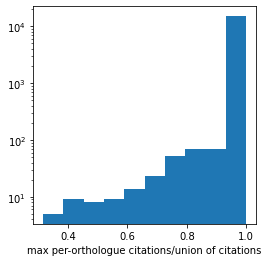

In [119]:
plt.hist(citation_stats['max_vs_union'])
plt.xlabel('max per-orthologue citations/union of citations')
plt.yscale('log')

In [120]:
print('n genes with citation sum>max:',(citation_stats['max_vs_union']<1).sum())

n genes with citation sum>max: 347


C: It seems that for most genes it would not matter if sum or max would be taken as the most cited orthologue is the only/mainly cited one.

Genes with lowest max/sum ratio - multiple orthologues strongly contributing to citations.

In [121]:
# Genes with lowest max/sum ratio
citation_stats.sort_values('max_vs_union').head(20)

,gene,gene_symbol,n_orthologues,n_pmid_orthologue_union,n_pmids_max,max_vs_union
14919,ENSMUSG00000058246,Gm10037,15,57,18,0.315789
14899,ENSMUSG00000098692,Gm28041,15,57,18,0.315789
14897,ENSMUSG00000098781,Gm28044,15,57,18,0.315789
7665,ENSMUSG00000055150,Zfp78,23,114,40,0.350877
6817,ENSMUSG00000045466,Zfp956,9,43,16,0.372093
16897,ENSMUSG00000076937,Iglc2,6,94,37,0.393617
16894,ENSMUSG00000105906,Iglc1,6,94,37,0.393617
16895,ENSMUSG00000105547,Iglc3,6,94,37,0.393617
5186,ENSMUSG00000028591,Pramel13,22,15,6,0.400000
5185,ENSMUSG00000046862,Pramel12,22,15,6,0.400000


Since orthologues that are all cited may have shared function the sum will be taken rather than max.

Cunt PMIDs and also make adjusted count that excludes publications that may not be relevant for our diabetes and beta cell dysfunction analyses (e.g. not related to pancreas or focused on exocrine or cancer).

In [122]:
# PMID counts
genes.drop([col for col in genes if 'N_PMID' in col],axis=1,inplace=True)
curr_gene_idx=0
for gene in genes.index:
    pmids_gene=set([pmid for pmids in list(pmid_sets['genes'][gene].values()) for pmid in pmids])
    genes.at[gene,'N_PMID']=len(pmids_gene)  
    genes.at[gene,'N_PMID_pancreas']=len(pmids_gene&pmid_sets['keys']['pancreas'])
    genes.at[gene,'N_PMID_pancreas_notCancer']=\
        len(pmids_gene&pmid_sets['keys']['pancreas']-pmid_sets['keys']['cancer'])
    genes.at[gene,'N_PMID_pancreas_notNonendo']=\
        len(pmids_gene&pmid_sets['keys']['pancreas']-pmid_sets['keys']['nonendocrine_refined'])
    genes.at[gene,'N_PMID_pancreas_notCancerNonendo']=\
        len(pmids_gene&pmid_sets['keys']['pancreas']-pmid_sets['keys']['cancer']\
            -pmid_sets['keys']['nonendocrine_refined'])
    curr_gene_idx+=1
    if curr_gene_idx%500==0:
        print('Analysed %i/%i genes'% (curr_gene_idx,n_genes))

Analysed 500/19351 genes
Analysed 1000/19351 genes
Analysed 1500/19351 genes
Analysed 2000/19351 genes
Analysed 2500/19351 genes
Analysed 3000/19351 genes
Analysed 3500/19351 genes
Analysed 4000/19351 genes
Analysed 4500/19351 genes
Analysed 5000/19351 genes
Analysed 5500/19351 genes
Analysed 6000/19351 genes
Analysed 6500/19351 genes
Analysed 7000/19351 genes
Analysed 7500/19351 genes
Analysed 8000/19351 genes
Analysed 8500/19351 genes
Analysed 9000/19351 genes
Analysed 9500/19351 genes
Analysed 10000/19351 genes
Analysed 10500/19351 genes
Analysed 11000/19351 genes
Analysed 11500/19351 genes
Analysed 12000/19351 genes
Analysed 12500/19351 genes
Analysed 13000/19351 genes
Analysed 13500/19351 genes
Analysed 14000/19351 genes
Analysed 14500/19351 genes
Analysed 15000/19351 genes
Analysed 15500/19351 genes
Analysed 16000/19351 genes
Analysed 16500/19351 genes
Analysed 17000/19351 genes
Analysed 17500/19351 genes
Analysed 18000/19351 genes
Analysed 18500/19351 genes
Analysed 19000/19351 

Check how many genes have citations in each of the citation groups

In [123]:
# N genes having >0 citations in each category
(genes[[col for col in genes if 'N_PMID' in col]]>0).sum()

N_PMID                              15350
N_PMID_pancreas                      8348
N_PMID_pancreas_notCancer            6348
N_PMID_pancreas_notNonendo           7721
N_PMID_pancreas_notCancerNonendo     6099
dtype: int64

C: The  procedure for removing non-endo papers seems to work well, most of the removed genes overlap with cancer-removed genes.

Check how high rankl based on N_PMID or N_PMID_pancreas have genes extracted from pancreas literature (e.g. papers that I got for geting familiarised wit the field at the start of my PhD and then made notes on relevant genes). These genes are expected to be important and should thus be highly cited if we want to use this metric.

In [124]:
# Genes from lietarture - put in lowercase as names may be human/mouse, etc
# Not all names are according to nomenclature
gene_collection=pd.read_excel('/lustre/groups/ml01/workspace/karin.hrovatin//data/pancreas/gene_lists/summary.xlsx',sheet_name='genes')
markers=pd.read_excel('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/markers.xlsx', 
                      sheet_name='mice')
collected_genes=set([g.lower() for g in gene_collection.Gene.tolist()+markers.Gene.tolist() 
                     if isinstance(g,str)])

Rank all genes by N PMIDs (with different filters) and then plot ranks distn for genes collected in my notes. Compare ranks distn on all genes and likely-relevant (notes) genes under different N PMID filtering regimes.

In [130]:
# Rank genes based on N_PMID
# Use lowercase symbols to match above
pmid_rank=pd.DataFrame({'rank_N_PMID':genes['N_PMID'].rank(ascending=False).values,
                        'rank_N_PMID_pancreas':genes['N_PMID_pancreas'].rank(ascending=False).values,
                       'rank_N_PMID_pancreas_notCancerNonendo':\
                        genes['N_PMID_pancreas_notCancerNonendo'].rank(ascending=False).values,
                       },index=[g.lower() if isinstance(g,str) else g for  g in genes.gene_symbol])

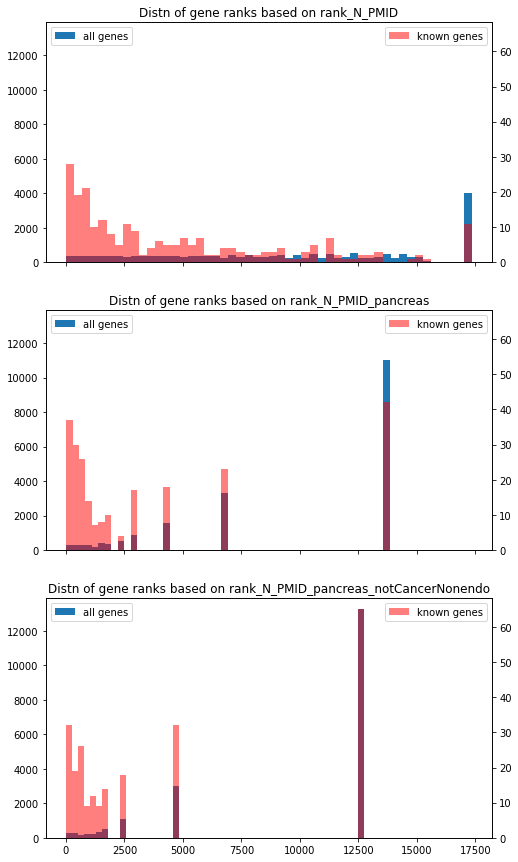

In [131]:
# Compare ranks of known genes with PMID or PMID_pancreas and with gene-wide distn of both
genes_known_overlap=[g for g in collected_genes if g in pmid_rank.index]
fig,ax=plt.subplots(3,1,figsize=(8,15),sharey=True,sharex=True)
ax2s=[]
for idx,col in enumerate(['rank_N_PMID','rank_N_PMID_pancreas',
                          'rank_N_PMID_pancreas_notCancerNonendo']):
    ax[idx].hist(pmid_rank.loc[:,col],bins=50,label='all genes')
    ax2=ax[idx].twinx()
    ax2s.append(ax2)
    ax2.hist(pmid_rank.loc[genes_known_overlap,col],label='known genes', 
             alpha=0.5,bins=50,color='r')
    ax[idx].set_title('Distn of gene ranks based on '+col)
    ax[idx].legend(loc='upper left')
    ax2.legend(loc='upper right')
max_y_ax2=max([ax2.get_ylim()[1] for a in ax2s])
for ax2 in ax2s:
    ax2.set_ylim(0,max_y_ax2)

C: N_PMID_pancreas has many more 0-s thus many genes have the same rank. But using pancreas/diabetes related PMIDs seems to shift the distn of known genes towards high ranks more strongly.

C: Some known pancreas/diabetes genes were found in no papers with indra (lowest rank is 0 found PMIDs). This must be kept in mind when using this for prioritisation. 

Further look into "relevant" genes that got ranked as worst (e.g. when I was making the list of the relevant genes I was starting so I could have actually collected less relevant genes as well).

In [132]:
pmid_rank.loc[genes_known_overlap,'rank_N_PMID_pancreas'].sort_values(ascending=False)[:50]

morf4l1     13850.0
egr4        13850.0
cdkn2a      13850.0
exoc6       13850.0
hmgn1       13850.0
ttyh2       13850.0
wnt4        13850.0
ccl5        13850.0
cfap126     13850.0
ybx1        13850.0
mfng        13850.0
slc38a5     13850.0
s100a1      13850.0
notum       13850.0
fam183b     13850.0
syt13       13850.0
rcor2       13850.0
frzb        13850.0
ndufa4l2    13850.0
hhex        13850.0
irx2        13850.0
btbd17      13850.0
cbfa2t2     13850.0
adgre1      13850.0
cd3d        13850.0
plp1        13850.0
mdk         13850.0
cox6a2      13850.0
sertm1      13850.0
cbfa2t3     13850.0
trac        13850.0
lurap1l     13850.0
cbx3        13850.0
myt1        13850.0
slitrk6     13850.0
pou3f1      13850.0
irx1        13850.0
tff3        13850.0
ppy         13850.0
lyz2        13850.0
cer1        13850.0
cd52        13850.0
numbl        6683.5
reep5        6683.5
btg2         6683.5
smarcd2      6683.5
id4          6683.5
pou6f2       6683.5
cspg4        6683.5
mtch1        6683.5


C: Some important genes have very low rank (found in no studies related to diabetes/pancreas). There are also some genes with no studies at all (not limiting to pancreas) - may not have orthologues, their PMID entires are not currated well, ...

Some genes have less currated entries than all entries (e.g. genes may be mentioned in a paper, but this is not currated in the gene entry). Thus check (for random set of genes due to compute time contraints) how many entries they have in currated vs general serach.

In [136]:
# Compare N obtained PMIDs if using curated or uncurated gene search
n_pmids=[]
i=0
for gene in np.random.permutation(orthologues['Human gene name'].unique()):
    try:
        n_pmids.append({'n_currated':len(set(literature.pubmed_client.get_ids_for_gene(gene))),
                   'n_search':literature.pubmed_client.get_id_count(gene)})
        i+=1
    except ValueError:
        pass
    if i==100:
        break
n_pmids=pd.DataFrame(n_pmids)

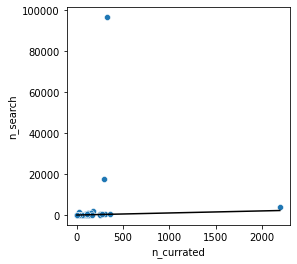

In [143]:
g=sb.scatterplot(x='n_currated',y='n_search',data=n_pmids)
plt.plot([0,n_pmids['n_currated'].max()],[0,n_pmids['n_currated'].max()],c='k')

C: In some cases using uncurated serach produces many more paper associations. But most genes follow 1,1 line (black).

Thus I will use the currated entries as they wil not be plagued by false positives.

## Metrics comparison

Relationship between n_cells and relative beta expression.

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


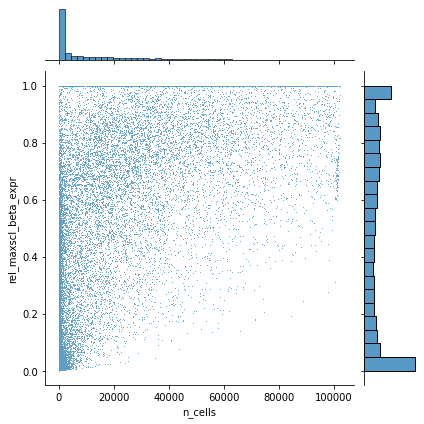

In [21]:
sb.jointplot(genes['n_cells'],genes['rel_maxscl_beta_expr'],s=1)

C: Most highly expressed genes do not look like potential ambient genes.

Relationship between citations likely associated with endocrine compartment and n_cells where gene is expressed

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


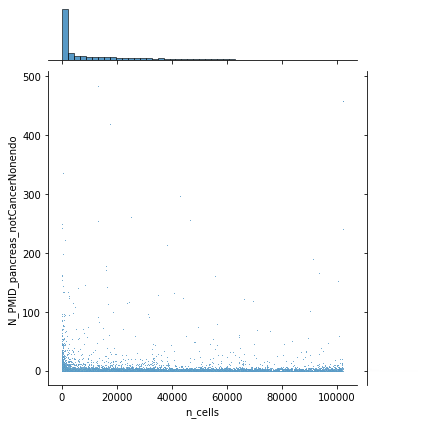

In [20]:
sb.jointplot(genes['n_cells'],genes['N_PMID_pancreas_notCancerNonendo'],s=1)

C: It seems that even lowly expressed genes have many citations. Thus the citation counting is likely not biased by expression.

Different relative expression scaling startegies.

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


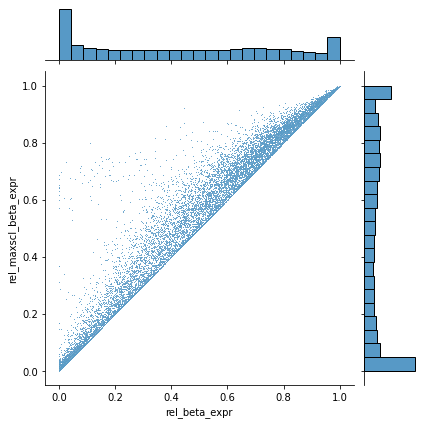

In [40]:
sb.jointplot(genes['rel_beta_expr'],genes['rel_maxscl_beta_expr'],s=1)

C: If using minmax instead of maxabs expr some genes would get much lower scores. Problem as minmax scales to [0,1] across cts so even if highly expressed in min expr ct (e.g. difference between highest and lowest expr ct is small) it will get lower score.

Relative expression across cell types or clusters.

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


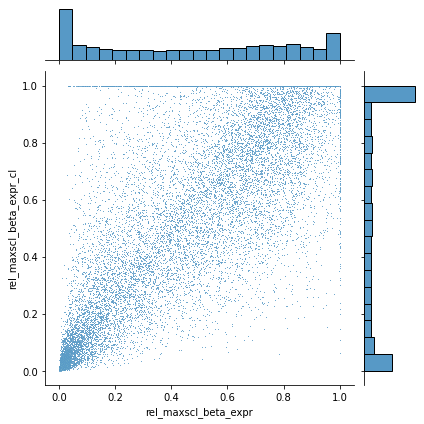

In [38]:
sb.jointplot(genes['rel_maxscl_beta_expr'],genes['rel_maxscl_beta_expr_cl'],s=1)

C: Using expression scaled based on ct or cl gives much different results. Using cls is probably better as accounts for cell state heterogeneity.

## Save

In [41]:
genes.to_csv(path_genes+'genePrioritisation_beta.tsv',sep='\t')

In [6]:
# Load
genes=pd.read_table(path_genes+'genePrioritisation_beta.tsv',index_col=0)

## Is n_cells statistic representative also for state-specific genes
The n_cells over all beta cells may be biased as cell states have different cell numbers. Compare n_cells (all cells) and ratio of cells in a given beta cell cluster that express the gene. 

NOTE: This section can be run only runing the notebooks for defining fine beta cell clusters.

In [32]:
# Ratio of cells per cl expressing each gene
ratio_subtypes=pd.DataFrame(index=adata_rn_b.var_names)
for cl in sorted(adata_rn_b.obs.hc_gene_programs.unique()):
    n_cells=(adata_rn_b.obs.hc_gene_programs==cl).sum()
    ratio_subtypes['ratio_expr_cl'+str(cl)]=np.array(
        (adata_rn_b[adata_rn_b.obs.hc_gene_programs==cl,:].X>0).sum(axis=0)
                ).ravel()/n_cells

In [33]:
# Save
ratio_subtypes.to_csv(path_genes+'ratioExpr_betaSubtypes.tsv',sep='\t')

In [28]:
path_genes+'ratioExpr_betaSubtypes.tsv'

'/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/ratioExpr_betaSubtypes.tsv'

In [4]:
# Load
#ratio_subtypes=pd.read_table(path_genes+'ratioExpr_betaSubtypes.tsv',index_col=0)

Check how expression across clusters coresponds to expression across all beta cells

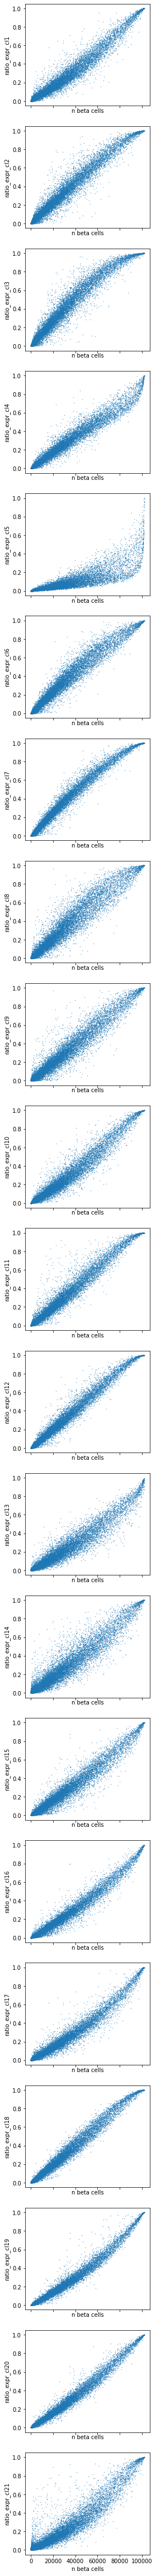

In [9]:
fig,ax=plt.subplots(ratio_subtypes.shape[1],1,figsize=(4,4*ratio_subtypes.shape[1]),
                    sharey=True,sharex=True)
for idx,cl in enumerate(ratio_subtypes.columns):
    ax[idx].scatter(genes.loc[ratio_subtypes.index,'n_cells'],ratio_subtypes[cl],s=0.1 )
    ax[idx].set_xlabel('n beta cells')
    ax[idx].set_ylabel(cl)

C: For most cell clusters expression cell ratio coresponds to all beta cells. However, for a few clusters this metric may be biased. This is mainly true for the cluster 5, which is low quality cluster (similar, but to lesser extent for cl4), so it is expected that genes are less expressed there than on the whole population. For other cluster some genes relatively highly expressed within the clusters may get a bit lower score on the whole beta cell population, but in general now extremely lower.